# T025 · Kinase similarity: Kinase pocket (KiSSim fingerprint)

Authors:

- Talia B. Kimber, 2021, [Volkamer lab, Charité](https://volkamerlab.org/)
- Dominique Sydow, 2021, [Volkamer lab, Charité](https://volkamerlab.org/)
- Andrea Volkamer, 2021, [Volkamer lab, Charité](https://volkamerlab.org/)

## Aim of this talktorial

We will assess the similarity between a set of kinases based on the KiSSim fingerprint, which describes the physicochemical and spatial properties in structurally resolved kinases.

### Contents in *Theory*

* Kinase dataset
* Kinase similarity descriptor: Kinase pockets (KiSSim fingerprint)
* Fetching KLIFS data with `opencadd.databases.klifs`

### Contents in *Practical*

* Retrieve and preprocess data
* Show kinase coverage
* Encode and compare structures
* Map structure to kinase distance matrix
* Save kinase distance matrix

### References

* Kinase dataset: [<i>Molecules</i> (2021), <b>26(3)</b>, 629](https://www.mdpi.com/1420-3049/26/3/629) 
* Protein Data Bank
  * PDB URL: http://www.rcsb.org/
  * PDB database: [<i>Acta Cryst.</i> (2002), <b>D58</b>, 899-907](https://doi.org/10.1107/S0907444902003451) and [<i>Structure</i> (2012), <b>20(3)</b>, 391-396](https://doi.org/10.1016/j.str.2012.01.010)
* KLIFS
  * KLIFS URL: https://klifs.net/
  * KLIFS database: [<i>Nucleic Acid Res.</i> (2020), <b>49(D1)</b>, D562-D569](https://doi.org/10.1093/nar/gkaa895)
  * KLIFS binding site definition: [<i>J. Med. Chem.</i> (2014), <b>57(2)</b>, 249-277](https://doi.org/10.1021/jm400378w)
 * Binding site comparison reviews: 
   * [<i>Curr. Comput. Aided Drug Des. </i> (2008), <b>4</b>, 209-20](https://www.eurekaselect.com/67606/article/how-measure-similarity-between-protein-ligand-binding-sites)
    * [<i>J. Med. Chem. </i> (2016), <b>9</b>, 4121-51](https://pubs.acs.org/doi/10.1021/acs.jmedchem.6b00078)
* KiSSim: Kinase Structural Similarity
  * GitHub repository: https://github.com/volkamerlab/kissim
  * Documentation: https://kissim.readthedocs.io
* `opencadd`, a Python library for structural cheminformatics
  * GitHub repository: https://github.com/volkamerlab/opencadd
  * Documentation: https://opencadd.readthedocs.io

## Theory

### Kinase dataset

We will use nine kinases from [<i>Molecules</i> (2021), <b>26(3)</b>, 629](https://www.mdpi.com/1420-3049/26/3/629), which aimed to understand kinase similarities within different combinations of kinase on- and off-targets (also called anti-targets):

> We aggregated the investigated kinases in “profiles”. Profile 1 combined **EGFR** and **ErbB2** as targets and **BRAF** as a (general) anti-target. Out of similar considerations, Profile 2 consisted of EGFR and **PI3K** as targets and BRAF as anti-target. This profile is expected to be more challenging as PI3K is an atypical kinase and thus less similar to EGFR than for example ErbB2 used in Profile 1. Profile 3, comprised of EGFR and **VEGFR2** as targets and BRAF as anti-target, was contrasted with the hit rate that we found with a standard docking against the single target VEGFR2 (Profile 4).
> To broaden the comparison and obtain an estimate for the promiscuity of each compound, the kinases **CDK2**, **LCK**, **MET** and **p38α** were included in the experimental assay panel and the structure-based bioinformatics comparison as commonly used anti-targets.

*Table 1:* 
Kinases used in this notebook, adapted from [<i>Molecules</i> (2021), <b>26(3)</b>, 629](https://www.mdpi.com/1420-3049/26/3/629), with their synonyms, UniProt IDs, and kinase groups.

| Kinase                     | Synonyms               | UniProt ID | Group    | Full kinase name                                 |
|----------------------------|------------------------|------------|----------|--------------------------------------------------|
| EGFR                       | ErbB1                  | P00533     | TK       | Epidermal growth factor receptor                 |
| ErbB2                      | Her2                   | P04626     | TK       | Erythroblastic leukemia viral oncogene homolog 2 |
| PI3K                       | PI3KCA, p110a          | P42336     | Atypical | Phosphatidylinositol-3-kinase                    |
| VEGFR2                     | KDR                    | P35968     | TK       | Vascular endothelial growth factor receptor 2    |
| BRAF                       | -                      | P15056     | TKL      | Rapidly accelerated fibrosarcoma isoform B       |
| CDK2                       | -                      | P24941     | CMGC     | Cyclic-dependent kinase 2                        |
| LCK                        | -                      | P06239     | TK       | Lymphocyte-specific protein tyrosine kinase      |
| MET                        | -                      | P08581     | TK       | Mesenchymal-epithelial transition factor         |
| p38a                       | MAPK14                 | Q16539     | CMGC     | p38 mitogen activated protein kinase α           |

### Kinase similarity descriptor: Kinase pockets (KiSSim fingerprint)

Side effects often occur when a drug binds not only to its designated target (on-target) but also to other targets (off-targets) that share similar binding sites to form similar protein-ligand interaction patterns. Many binding site comparison tools have been proposed to predict similarities and potentially off-targets. We here use the KiSSim (*Ki*nase *S*tructure *Sim*ilarity) fingerprint, which is based on the KLIFS pocket definition and alignment described in the following.

The KLIFS database ([<i>Nucleic Acid Res.</i> (2020), <b>49(D1)</b>, D562-D569](https://doi.org/10.1093/nar/gkaa895), [<i>J. Med. Chem.</i> (2014), <b>57(2)</b>, 249-277](https://doi.org/10.1021/jm400378w)) fetches all kinase structures deposited in the structural database PDB ([<i>Acta Cryst.</i> (2002), <b>D58</b>, 899-907](https://doi.org/10.1107/S0907444902003451), [<i>Structure</i> (2012), <b>20(3)</b>, 391-396](https://doi.org/10.1016/j.str.2012.01.010)) and processes them as follows: All multi-chain structures in the PDB are split into monomers and aligned to each other with a special focus on a pre-defined binding site of 85 residues (Figure 1). For example, this means that the conserved gatekeeper (GK) residue at KLIFS position 45 can be easily and quickly looked up in any of the over 10,000 monomeric kinase structures in KLIFS. 

![KLIFS binding site](https://klifs.net/images/faq/xcolors.png.pagespeed.ic.dprMuoZGzn.webp)

*Figure 1:* 
Kinase binding site residues as defined by KLIFS.
Figure and description taken from: [<i>J. Med. Chem.</i> (2014), <b>57(2)</b>, 249-277](https://doi.org/10.1021/jm400378w).

The KiSSim fingerprint encodes each of the 85 residues in the KLIFS binding site with respect to physicochemical and spatial properties (Figure 2). Since all KLIFS pockets are aligned across the structurally covered kinome, we can compare the KiSSim fingerprints bit by bit. Physicochemical properties include each residue's pharmacophoric features, size, side chain orientation, and solvent exposure. Spatial properties describe the distance of each residue to defined important regions in the kinase pocket, for example the hinge region, which forms crucial hydrogen bonds to ligands, or the DFG region, whose conformation determines the activity state of the kinase.

![KiSSim fingerprint](https://raw.githubusercontent.com/volkamerlab/kissim/main/docs/_static/kissim_toc.png)

*Figure 2:* 
The KiSSim fingerprint encodes physicochemical and spatial properties of a kinase binding site.
Figure taken from: https://github.com/volkamerlab/kissim

### Fetching KLIFS data with `opencadd.databases.klifs`

`opencadd` is a Python library for structural cheminformatics developed by the Volkamer lab at the Charité in Berlin. 
This library is a growing collection of modules that help facilitate and standardize common tasks in structural bioinformatics and cheminformatics. Today, we will use the module `opencadd.databases.klifs`, which allows us to fetch the KLIFS IFP as `pandas` DataFrame.

- GitHub repository: https://github.com/volkamerlab/opencadd
- Documentation: https://opencadd.readthedocs.io

For more information about this library and the KLIFS OpenAPI, please refer to __Talktorial T012__.

## Practical

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.metrics import pairwise
import matplotlib.pyplot as plt
import seaborn as sns
from opencadd.databases.klifs import setup_remote

In [2]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

### Retrieve and preprocess data

Let's define our kinases of interest and all their synonyms as described in Table 1 in the global variable `query_kinases`.

In [3]:
query_kinases = [
    "EGFR",
    "ErbB2",
    "Her2",
    "PI3K",
    "PI3KCA",
    "p110a",
    "BRAF",
    "CDK2",
    "LCK",
    "MET",
    "p38a",
    "MAPK14",
    "VEGFR2",
    "KDR",
]

Now, we query the KLIFS database using the `opencadd.databases.klifs` module to generate our IFP dataset.

#### Set up a remote KLIFS session

In [4]:
from opencadd.databases.klifs import setup_remote

In [5]:
klifs_session = setup_remote()

#### Fetch all structures describing these kinases

In [6]:
structures = klifs_session.structures.by_kinase_name(kinase_names=query_kinases)
print(f"Number of structures: {len(structures)}")
print("Kinases:", *structures["kinase.klifs_name"].unique())

Number of structures: 2466
Kinases: CDK2 p38a EGFR ErbB2 MET LCK KDR BRAF p110a


#### Filter structures

We filter the structures by different criteria:

- Species: human
- Conformation: DFG-in (the active kinase conformation)
- Resolution: $\le 3$ Angström
- Quality score*: $\ge 6$

\* The KLIFS quality score takes into account the quality of the alignment and the number of missing residues and atoms (the higher the better the structure quality).

In [7]:
structures = structures[
    (structures["species.klifs"] == "Human")
    & (structures["structure.dfg"] == "in")
    & (structures["structure.resolution"] <= 3)
    & (structures["structure.qualityscore"] >= 6)
]
print(f"Number of structures: {len(structures)}")
print("Kinases:", *structures["kinase.klifs_name"].unique())

Number of structures: 1620
Kinases: CDK2 p38a EGFR ErbB2 MET LCK KDR BRAF p110a


Save the structure KLIFS IDs for the next step.

In [8]:
structure_klifs_ids = structures["structure.klifs_id"].to_list()
print(f"Number of structures: {len(structure_klifs_ids)}")

Number of structures: 1620


To make it easier for us to maintain the talktorials, we will load now a set of frozen structure KLIFS IDs (2021-08-23) and continue to work with those. If you would like to work with the latest KLIFS data, please uncomment the cell below.

In [9]:
# Load frozen dataset
structure_klifs_ids = pd.read_csv(DATA / "frozen_structure_klifs_ids.csv")[
    "structure.klifs_id"
].to_list()
print(f"Number of structures: {len(structure_klifs_ids)}")
# NBVAL_CHECK_OUTPUT

Number of structures: 1620


### Show kinase coverage

Let's get the number of structures that describe our kinases (kinase coverage).

In [10]:
# Use pandas' groupby method to count the number of structures (rows) per kinase
n_structures_per_kinase = structures.groupby("kinase.klifs_name").size().sort_values()
n_structures_per_kinase
# NBVAL_CHECK_OUTPUT

kinase.klifs_name
ErbB2      4
KDR        6
LCK       32
p110a     49
BRAF      72
MET       99
p38a     151
EGFR     357
CDK2     850
dtype: int64

Let's plot our results.

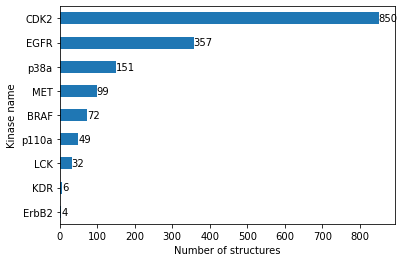

In [11]:
fig, ax = plt.subplots()
n_structures_per_kinase.plot(kind="barh", ax=ax)
ax.set_xlabel("Number of structures")
ax.set_ylabel("Kinase name")
for i, value in enumerate(n_structures_per_kinase):
    ax.text(value, i, str(value), va="center")

We see that our dataset is highly imbalanced. While some kinases are structurally resolved very often, other kinases are not: See e.g. CDK2 and EGFR vs. KDR and ErbB2. We will have to keep this in mind when interpreting our results later.

### Load KiSSim fingerprints

We will use in this notebook pre-calculated KiSSim fingerprints for our kinase set. If you wanted to calculate the fingerprints yourself, you can use the following `kissim` API: 

```python
# Generate fingerprints
from kissim.api import encode
kissim_fingerprints = encode(structure_klifs_ids, n_cores=1)

# Save fingerprints as csv files
structure_klifs_ids = list(kissim_fingerprints.data.keys())
kissim_fingerprints_array = [
    fingerprint.values_array().tolist()
    for structure_klifs_id, fingerprint
    in kissim_fingerprints.data.items()
]
kissim_fingerprints_array = np.array(kissim_fingerprints_array)
kissim_fingerprints_df = pd.DataFrame(kissim_fingerprints_array, index=structure_klifs_ids)
kissim_fingerprints_df.to_csv(DATA / "kissim_fingerprints.csv")
```

Let's load the pre-calculated KiSSim fingerprints!

In [12]:
kissim_fingerprints = pd.read_csv(DATA / "kissim_fingerprints.csv", index_col=0)
print(f"Matrix shape: {kissim_fingerprints.shape}")
print(f"Number of fingerprints: {kissim_fingerprints.shape[0]}")
print(f"Number of fingerprint bits: {kissim_fingerprints.shape[1]}")

Matrix shape: (1611, 1032)
Number of fingerprints: 1611
Number of fingerprint bits: 1032


You might notice that we have fewer fingerprints than structures. This can happen during the `kissim` fingerprinting when some structures cannot be encoded.

### Compare structures

Let's compare the KiSSim fingerprints pairwise. We use `sklearn`'s `nan_euclidean_distances` method, which calculates the Euclidean distance between all pairwise vectors of a matrix. 

If two vectors have NaN values (which can happen if residues are not resolved in a structure), the following procedure is applied:

>  When calculating the distance between a pair of samples, this formulation ignores feature coordinates with a missing value in either sample and scales up the weight of the remaining coordinates.

Please find more information in their documentation:

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.nan_euclidean_distances.html

In [13]:
structure_distance_matrix = pairwise.nan_euclidean_distances(kissim_fingerprints.values)
structure_distance_matrix

array([[ 0.        , 13.25694052, 14.00147438, ..., 50.66954295,
        50.7622906 , 50.9508342 ],
       [13.25694052,  0.        , 10.37977891, ..., 50.76260217,
        51.20730054, 51.4472163 ],
       [14.00147438, 10.37977891,  0.        , ..., 51.94849587,
        52.88538294, 52.73268888],
       ...,
       [50.66954295, 50.76260217, 51.94849587, ...,  0.        ,
         8.24900205,  6.08783522],
       [50.7622906 , 51.20730054, 52.88538294, ...,  8.24900205,
         0.        ,  7.94854801],
       [50.9508342 , 51.4472163 , 52.73268888, ...,  6.08783522,
         7.94854801,  0.        ]])

In [14]:
# Create DataFrame with structure KLIFS IDs as index/columns
structure_klifs_ids = kissim_fingerprints.index.to_list()
structure_distance_matrix = pd.DataFrame(
    structure_distance_matrix, index=structure_klifs_ids, columns=structure_klifs_ids
)
print(f"Structure distance matrix size: {structure_distance_matrix.shape}")
print("Show matrix subset:")
structure_distance_matrix.iloc[:5, :5]

Structure distance matrix size: (1611, 1611)
Show matrix subset:


,6285,10568,11187,4060,10566
6285,0.000000,13.256941,14.001474,26.391543,14.307291
10568,13.256941,0.000000,10.379779,27.882193,16.833932
11187,14.001474,10.379779,0.000000,30.962221,18.338492
4060,26.391543,27.882193,30.962221,0.000000,28.905189
10566,14.307291,16.833932,18.338492,28.905189,0.000000


### Map structure to kinase distance matrix

First &mdash; as an intermediate step &mdash; we will create a structure distance matrix but instead of labeling the data with structure KLIFS IDs we add the corresponding kinase name.

In [15]:
# Copy distance matrix to kinase matrix
kinase_distance_matrix = structure_distance_matrix
# Replace structure KLIFS IDs with the structures' kinase names
kinase_names = structures.set_index("structure.klifs_id").loc[
    structure_klifs_ids, "kinase.klifs_name"
]
kinase_distance_matrix.index = kinase_names
kinase_distance_matrix.columns = kinase_names
print("Show matrix subset:")
kinase_distance_matrix.iloc[:5, :5]

Show matrix subset:


kinase.klifs_name,CDK2,CDK2,CDK2,CDK2,CDK2
kinase.klifs_name,,,,,
CDK2,0.000000,13.256941,14.001474,26.391543,14.307291
CDK2,13.256941,0.000000,10.379779,27.882193,16.833932
CDK2,14.001474,10.379779,0.000000,30.962221,18.338492
CDK2,26.391543,27.882193,30.962221,0.000000,28.905189
CDK2,14.307291,16.833932,18.338492,28.905189,0.000000


In this talktorial, we will consider per kinase pair the two structures that show the most similar binding mode for their co-crystallized ligands. Hence, we select the structure pair with the minimum distance as representative for a kinase pair.

In [16]:
# We unstack the matrix (each pairwise comparison in a single row)
# We group by kinase names (level=[0, 1] ensures that the order of the kinases is ignored
# We take the minimum value in each kinase pair group
# We unstack the remaining data points
kinase_distance_matrix = (
    kinase_distance_matrix.unstack().groupby(level=[0, 1]).min().unstack(level=1)
)
# Show matrix with background gradient
# Show matrix with background gradient
cm = sns.light_palette("green", as_cmap=True)
kinase_distance_matrix.style.background_gradient(cmap=cm).format("{:.3f}")

kinase.klifs_name,BRAF,CDK2,EGFR,ErbB2,KDR,LCK,MET,p110a,p38a
kinase.klifs_name,,,,,,,,,
BRAF,0.000,17.156,19.515,21.383,21.089,21.583,20.297,37.611,21.731
CDK2,17.156,0.000,18.147,21.106,19.880,17.973,18.304,36.780,19.481
EGFR,19.515,18.147,0.000,16.392,17.282,16.467,17.498,36.046,22.128
ErbB2,21.383,21.106,16.392,0.000,23.851,23.881,22.563,41.277,24.682
KDR,21.089,19.880,17.282,23.851,0.000,19.255,20.431,41.104,20.263
LCK,21.583,17.973,16.467,23.881,19.255,0.000,19.221,39.022,22.457
MET,20.297,18.304,17.498,22.563,20.431,19.221,0.000,39.414,21.983
p110a,37.611,36.780,36.046,41.277,41.104,39.022,39.414,0.000,38.530
p38a,21.731,19.481,22.128,24.682,20.263,22.457,21.983,38.530,0.000


### Save kinase distance matrix

In [17]:
kinase_distance_matrix.index.name = None
kinase_distance_matrix.columns.name = None
kinase_distance_matrix.to_csv(DATA / "kinase_distance_matrix_kissim.csv")

## Discussion

In this talktorial, we have assessed kinase similarity used KiSSim fingerprints, which describe physicochemical and spatial properties of pockets in kinase structures. We have reduced a structure distance matrix to a kinase distance matrix by selecting for each kinase pair the corresponding closest structure pair. 

The kinase distance matrix above will be reloaded in **Talktorial T028**, where we compare kinase similarities from different perspectives, including the pocket structure perspective we have talked about in this talktorial.

## Quiz

1. Can you think of reasons why it is important to include physicochemical *and* spatial properties in a fingerprint?
2. Can you think of a reason why the side chain orientation and solvent exposure may be interesting features to consider in a fingerprint?
2. Can you think of research questions for which you could make use of the structure distance matrix?